In [1]:
%%capture
!pip install pandas nltk scikit-learn

In [2]:
import numpy as np
import pandas as pd
import nltk
from preprocessing import lowercase_data, remove_punctuation, remove_stopwords, LemmatizerOrStemmer, WordSimplification
from typing import Tuple, Dict, List, Union, Set
from evaltools import evaluate

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/serms/.config/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/serms/.config/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/serms/.config/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
dtypes = {
    'ArticleId': 'int32',
    'Text': 'str',
    'Category': 'category'
}
data_train = pd.read_csv('data/BBC News Train.csv', dtype=dtypes, encoding='utf-8', index_col='ArticleId')
data_test = pd.read_csv('data/BBC News Test.csv', dtype={'ArticleId': 'int32', 'Text': 'str'}, encoding='utf-8', index_col='ArticleId')
data_test_solution = pd.read_csv('data/BBC News Sample Solution.csv', dtype={'ArticleId': 'int32', 'Category': 'category'}, encoding='utf-8', index_col='ArticleId')
data_test['Category'] = data_test_solution['Category']
data = pd.concat([data_train, data_test])
data.head(10)

,Text,Category
ArticleId,,
1833,worldcom ex-boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens in ...,business
1976,lifestyle governs mobile choice faster bett...,tech
917,enron bosses in $168m payout eighteen former e...,business
1582,howard truanted to play snooker conservative...,politics
651,wales silent on grand slam talk rhys williams ...,sport
1797,french honour for director parker british film...,entertainment
2034,car giant hit by mercedes slump a slump in pro...,business


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2225 entries, 1833 to 471
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Text      2225 non-null   object  
 1   Category  2225 non-null   category
dtypes: category(1), object(1)
memory usage: 28.5+ KB


In [5]:
data.Category.value_counts()

Category
sport            493
business         483
politics         421
entertainment    420
tech             408
Name: count, dtype: int64

## Preprocessing

In [6]:
def data_preprocessing(data: Union[pd.Series, List[str], str], stopwords: Set[str]) -> Union[pd.Series, List[str], str]:
    data = lowercase_data(data)
    data = remove_punctuation(data)
    data = remove_stopwords(data, stopwords)
    return data

In [7]:
from nltk.corpus import stopwords

english_stopwords = set(stopwords.words('english'))

data['Text'] = data_preprocessing(data['Text'], english_stopwords)
data.head(10)

,Text,Category
ArticleId,,
1833,worldcom ex boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens maj...,business
1976,lifestyle governs mobile choice faster better ...,tech
917,enron bosses payout eighteen former enron dire...,business
1582,howard truanted play snooker conservative lead...,politics
651,wales silent grand slam talk rhys williams say...,sport
1797,french honour director parker british film dir...,entertainment
2034,car giant hit mercedes slump slump profitabili...,business


In [8]:
word_simplifier_type = WordSimplification.LEMMATIZER
word_simplifier = LemmatizerOrStemmer(WordSimplification.LEMMATIZER)

data['Text'] = word_simplifier.simplify(data['Text'])
data.head(10)

,Text,Category
ArticleId,,
1833,worldcom ex boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens maj...,business
1976,lifestyle governs mobile choice faster better ...,tech
917,enron bosses payout eighteen former enron dire...,business
1582,howard truanted play snooker conservative lead...,politics
651,wales silent grand slam talk rhys williams say...,sport
1797,french honour director parker british film dir...,entertainment
2034,car giant hit mercedes slump slump profitabili...,business


In [9]:
user_interests: Dict[int, List[str]] = {
    1: ['politics'],
    2: ['entertainment'],
    3: ['sport'],
    4: ['tech'],
    5: ['business']
}

In [10]:
def flatten(xss):
    return [x for xs in xss for x in xs]

def preprocess_user_interests(user_interests: Dict[int, List[str]]) -> Dict[int, List[str]]:
    interests_processed = {}
    for user_id, interests in user_interests.items():
         interests_processed[user_id] = data_preprocessing(interests, english_stopwords)
    return interests_processed

num_documents_to_retrieve = 10  # Number of documents to retrieve for each user
user_interests = preprocess_user_interests(user_interests)
user_interests

{1: ['politics'],
 2: ['entertainment'],
 3: ['sport'],
 4: ['tech'],
 5: ['business']}

# TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

def get_tfidf(data: pd.Series, *, min_df: float = None, max_df: float = None, stop_words_language: str = 'english', max_features: int = 1000) -> Tuple[TfidfVectorizer, csr_matrix]:
    data = data.fillna('')
    vectorizer = TfidfVectorizer(min_df=min_df or 0.0, max_df=max_df or 1.0,  stop_words=stop_words_language, max_features=max_features)
    vectors = vectorizer.fit_transform(data)
    return vectorizer, vectors

In [12]:
vectorizer, document_vectors = get_tfidf(data['Text'], max_df=0.15, stop_words_language='english', max_features=1000)

In [13]:
document_vectors.shape

(2225, 1000)

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

user_retrieved_documents: Dict[int, pd.DataFrame] = {
    user_id: pd.DataFrame(
        index=data.index,
        columns=['SimilarityScore']
    )
    for user_id, _ in user_interests.items()
}

for user_id, interests in user_interests.items():
    print(f'User {user_id} have interests: [{", ".join(interests)}]')
    interests_simplified = word_simplifier.simplify(interests)
    top_k_to_print = num_documents_to_retrieve
    for interest in interests_simplified:
        query_vector = vectorizer.transform([interest])
        similarity_scores = cosine_similarity(query_vector, document_vectors)[0]
        top_documents_indices = similarity_scores.argsort()[::-1]
        for document_index in top_documents_indices:
            article_id = data.index[document_index]
            user_retrieved_documents[user_id].loc[article_id] = similarity_scores[document_index]
            if top_k_to_print > 0:
                print(f'\tDocument {article_id} with similarity score {similarity_scores[document_index]:.2f}'
                      f' and category {data.loc[article_id, "Category"]} -> {'OK' if data.loc[article_id, "Category"] in interests else 'WRONG'}')
                top_k_to_print -= 1

User 1 have interests: [politics]
	Document 642 with similarity score 0.57 and category sport -> WRONG
	Document 1792 with similarity score 0.49 and category politics -> OK
	Document 553 with similarity score 0.32 and category tech -> WRONG
	Document 2211 with similarity score 0.27 and category sport -> WRONG
	Document 825 with similarity score 0.27 and category politics -> OK
	Document 86 with similarity score 0.25 and category politics -> OK
	Document 14 with similarity score 0.25 and category politics -> OK
	Document 1104 with similarity score 0.24 and category politics -> OK
	Document 882 with similarity score 0.20 and category politics -> OK
	Document 2055 with similarity score 0.18 and category sport -> WRONG
User 2 have interests: [entertainment]
	Document 985 with similarity score 0.50 and category entertainment -> OK
	Document 326 with similarity score 0.28 and category politics -> WRONG
	Document 1090 with similarity score 0.26 and category entertainment -> OK
	Document 1147 

In [15]:
user_retrieved_documents[1].sort_values(by='SimilarityScore', ascending=False).head(num_documents_to_retrieve)

,SimilarityScore
ArticleId,
642,0.573825
1792,0.48704
553,0.321861
2211,0.27098
825,0.266631
14,0.254421
86,0.254421
1104,0.243485
882,0.199902


Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=0/1=0.00,	R(1)=0/6=0.00
		P(2)=1/2=0.50,	R(2)=1/6=0.17
		P(3)=1/3=0.33,	R(3)=1/6=0.17
		P(4)=1/4=0.25,	R(4)=1/6=0.17
		P(5)=2/5=0.40,	R(5)=2/6=0.33
		P(6)=3/6=0.50,	R(6)=3/6=0.50
		P(7)=4/7=0.57,	R(7)=4/6=0.67
		P(8)=5/8=0.62,	R(8)=5/6=0.83
		P(9)=6/9=0.67,	R(9)=6/6=1.00
		P(10)=6/10=0.60,	R(10)=6/6=1.00
	Query 2
		P(1)=1/1=1.00,	R(1)=1/4=0.25
		P(2)=1/2=0.50,	R(2)=1/4=0.25
		P(3)=2/3=0.67,	R(3)=2/4=0.50
		P(4)=2/4=0.50,	R(4)=2/4=0.50
		P(5)=2/5=0.40,	R(5)=2/4=0.50
		P(6)=2/6=0.33,	R(6)=2/4=0.50
		P(7)=3/7=0.43,	R(7)=3/4=0.75
		P(8)=4/8=0.50,	R(8)=4/4=1.00
		P(9)=4/9=0.44,	R(9)=4/4=1.00
		P(10)=4/10=0.40,	R(10)=4/4=1.00
	Query 3
		P(1)=0/1=0.00,	R(1)=0/4=0.00
		P(2)=0/2=0.00,	R(2)=0/4=0.00
		P(3)=0/3=0.00,	R(3)=0/4=0.00
		P(4)=1/4=0.25,	R(4)=1/4=0.25
		P(5)=1/5=0.20,	R(5)=1/4=0.25
		P(6)=1/6=0.17,	R(6)=1/4=0.25
		P(7)=1/7=0.14,	R(7)=1/4=0.25
		P(8)=2/8=0.25,	R(8)=2/4=0.50
		P(9)=3/9=0.33,	R(9)=3/4=0.75
		P(10)=4/10=0.40,	R(10)=4/

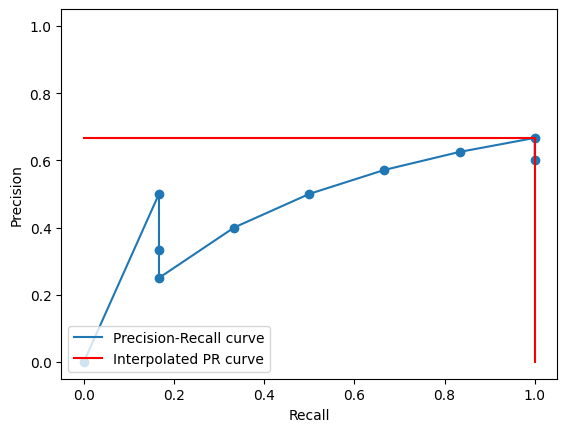

	Query 2


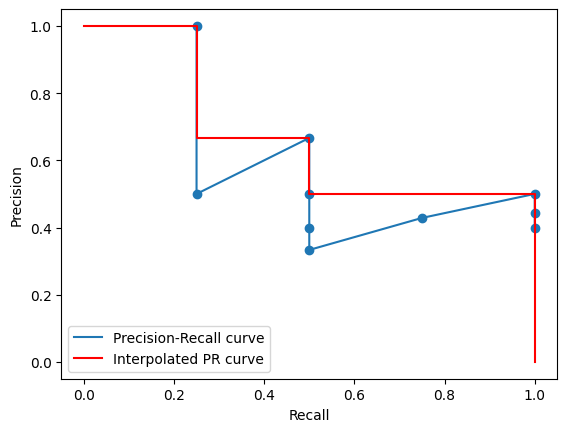

	Query 3


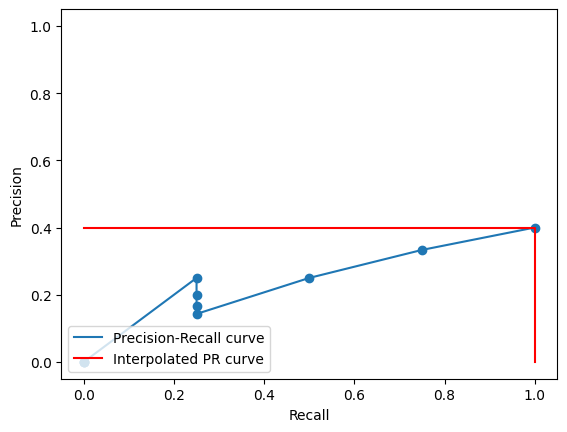

	Query 4


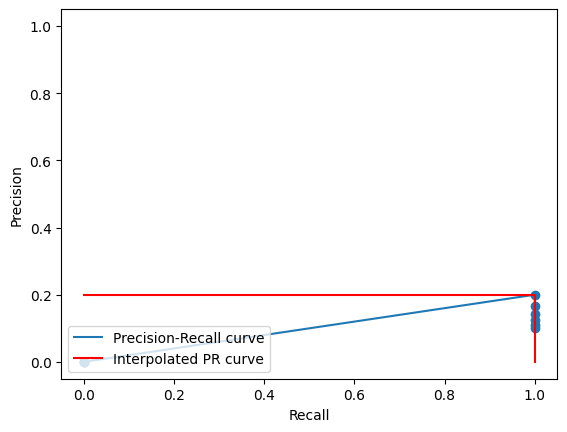

	Query 5


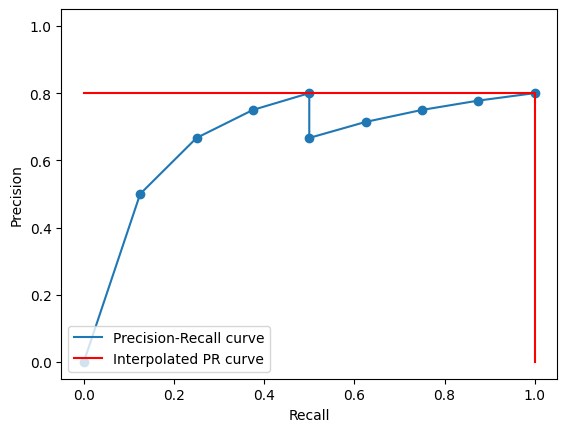

In [16]:
Q = []
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    Q.append(np.array(retrieved_documents.index))
    
R = []
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    R.append(np.array([1 if data.loc[article_id, 'Category'] in user_interests[user_id] else -1 for article_id in retrieved_documents.index])
)
    
evaluate('prec_rec', Q, R)

In [17]:
evaluate('r-prec', Q, R)

Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=0/1=0.00,	R(1)=0/6=0.00
		P(2)=1/2=0.50,	R(2)=1/6=0.17
		P(3)=1/3=0.33,	R(3)=1/6=0.17
		P(4)=1/4=0.25,	R(4)=1/6=0.17
		P(5)=2/5=0.40,	R(5)=2/6=0.33
		P(6)=3/6=0.50,	R(6)=3/6=0.50
		P(7)=4/7=0.57,	R(7)=4/6=0.67
		P(8)=5/8=0.62,	R(8)=5/6=0.83
		P(9)=6/9=0.67,	R(9)=6/6=1.00
		P(10)=6/10=0.60,	R(10)=6/6=1.00
	Query 2
		P(1)=1/1=1.00,	R(1)=1/4=0.25
		P(2)=1/2=0.50,	R(2)=1/4=0.25
		P(3)=2/3=0.67,	R(3)=2/4=0.50
		P(4)=2/4=0.50,	R(4)=2/4=0.50
		P(5)=2/5=0.40,	R(5)=2/4=0.50
		P(6)=2/6=0.33,	R(6)=2/4=0.50
		P(7)=3/7=0.43,	R(7)=3/4=0.75
		P(8)=4/8=0.50,	R(8)=4/4=1.00
		P(9)=4/9=0.44,	R(9)=4/4=1.00
		P(10)=4/10=0.40,	R(10)=4/4=1.00
	Query 3
		P(1)=0/1=0.00,	R(1)=0/4=0.00
		P(2)=0/2=0.00,	R(2)=0/4=0.00
		P(3)=0/3=0.00,	R(3)=0/4=0.00
		P(4)=1/4=0.25,	R(4)=1/4=0.25
		P(5)=1/5=0.20,	R(5)=1/4=0.25
		P(6)=1/6=0.17,	R(6)=1/4=0.25
		P(7)=1/7=0.14,	R(7)=1/4=0.25
		P(8)=2/8=0.25,	R(8)=2/4=0.50
		P(9)=3/9=0.33,	R(9)=3/4=0.75
		P(10)=4/10=0.40,	R(10)=4/

In [18]:
evaluate('map', Q, R)

Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=0/1=0.00,	R(1)=0/6=0.00
		P(2)=1/2=0.50,	R(2)=1/6=0.17
		P(3)=1/3=0.33,	R(3)=1/6=0.17
		P(4)=1/4=0.25,	R(4)=1/6=0.17
		P(5)=2/5=0.40,	R(5)=2/6=0.33
		P(6)=3/6=0.50,	R(6)=3/6=0.50
		P(7)=4/7=0.57,	R(7)=4/6=0.67
		P(8)=5/8=0.62,	R(8)=5/6=0.83
		P(9)=6/9=0.67,	R(9)=6/6=1.00
		P(10)=6/10=0.60,	R(10)=6/6=1.00
	Query 2
		P(1)=1/1=1.00,	R(1)=1/4=0.25
		P(2)=1/2=0.50,	R(2)=1/4=0.25
		P(3)=2/3=0.67,	R(3)=2/4=0.50
		P(4)=2/4=0.50,	R(4)=2/4=0.50
		P(5)=2/5=0.40,	R(5)=2/4=0.50
		P(6)=2/6=0.33,	R(6)=2/4=0.50
		P(7)=3/7=0.43,	R(7)=3/4=0.75
		P(8)=4/8=0.50,	R(8)=4/4=1.00
		P(9)=4/9=0.44,	R(9)=4/4=1.00
		P(10)=4/10=0.40,	R(10)=4/4=1.00
	Query 3
		P(1)=0/1=0.00,	R(1)=0/4=0.00
		P(2)=0/2=0.00,	R(2)=0/4=0.00
		P(3)=0/3=0.00,	R(3)=0/4=0.00
		P(4)=1/4=0.25,	R(4)=1/4=0.25
		P(5)=1/5=0.20,	R(5)=1/4=0.25
		P(6)=1/6=0.17,	R(6)=1/4=0.25
		P(7)=1/7=0.14,	R(7)=1/4=0.25
		P(8)=2/8=0.25,	R(8)=2/4=0.50
		P(9)=3/9=0.33,	R(9)=3/4=0.75
		P(10)=4/10=0.40,	R(10)=4/

# Word embeddings

In [19]:
import gensim.downloader as api

# Load pre-trained word embeddings
word_embeddings_model = api.load("word2vec-google-news-300")

In [20]:
# Function to generate document embeddings
def generate_document_embeddings(documents, word_embeddings_model):
    document_embeddings = []
    for doc in documents:
        # Aggregate word embeddings (e.g., by averaging)
        words = doc.split()
        embeddings = [word_embeddings_model[word] for word in words if word in word_embeddings_model]
        if embeddings:
            doc_embedding = np.mean(embeddings, axis=0)  # Average embeddings
            document_embeddings.append(doc_embedding)
    return np.array(document_embeddings)

# Function to retrieve relevant documents for a query
def retrieve_documents(query_embedding, document_embeddings, documents, document_ids):
    similarity_scores = cosine_similarity(query_embedding.reshape(1, -1), document_embeddings)[0]
    sorted_documents_indices = similarity_scores.argsort()[::-1]
    sorted_documents = [(document_ids.iloc[i], documents.iloc[i], similarity_scores[i]) for i in sorted_documents_indices]
    return sorted_documents

In [21]:
user_retrieved_documents: Dict[int, pd.DataFrame] = {
    user_id: pd.DataFrame(
        index=data.index,
        columns=['SimilarityScore']
    )
    for user_id, _ in user_interests.items()
}

# Generate document embeddings
document_embeddings = generate_document_embeddings(data['Text'], word_embeddings_model)

# Process user queries
for user_id, interests in user_interests.items():
    print(f'User {user_id} have interests: [{", ".join(interests)}]')
    interests_simplified = word_simplifier.simplify(interests)
    top_k_to_print = num_documents_to_retrieve
    query_embedding = np.mean([word_embeddings_model[interest] for interest in interests_simplified if interest in word_embeddings_model], axis=0)
    similarity_scores = cosine_similarity(query_embedding.reshape(1, -1), document_embeddings)[0]
    top_documents_indices = similarity_scores.argsort()[::-1]
    for document_index in top_documents_indices:
        article_id = data.index[document_index]
        user_retrieved_documents[user_id].loc[article_id] = similarity_scores[document_index]
        if top_k_to_print > 0:
                print(f'\tDocument {article_id} with similarity score {similarity_scores[document_index]:.2f}'
                      f' and category {data.loc[article_id, "Category"]} -> {'OK' if data.loc[article_id, "Category"] in interests else 'WRONG'}')
                top_k_to_print -= 1

User 1 have interests: [politics]
	Document 642 with similarity score 0.57 and category sport -> WRONG
	Document 1792 with similarity score 0.55 and category politics -> OK
	Document 825 with similarity score 0.50 and category politics -> OK
	Document 623 with similarity score 0.50 and category politics -> OK
	Document 2204 with similarity score 0.50 and category politics -> OK
	Document 882 with similarity score 0.49 and category politics -> OK
	Document 1570 with similarity score 0.48 and category politics -> OK
	Document 2084 with similarity score 0.48 and category politics -> OK
	Document 378 with similarity score 0.48 and category politics -> OK
	Document 517 with similarity score 0.48 and category politics -> OK
User 2 have interests: [entertainment]
	Document 1147 with similarity score 0.50 and category tech -> WRONG
	Document 930 with similarity score 0.44 and category tech -> WRONG
	Document 2059 with similarity score 0.44 and category entertainment -> OK
	Document 1183 with s

In [22]:
user_retrieved_documents[2].sort_values(by='SimilarityScore', ascending=False).head(num_documents_to_retrieve)

,SimilarityScore
ArticleId,
1147,0.495553
930,0.440858
2059,0.43738
1183,0.42067
985,0.420535
283,0.418167
1881,0.417321
794,0.417321
1937,0.415648


Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=0/1=0.00,	R(1)=0/9=0.00
		P(2)=1/2=0.50,	R(2)=1/9=0.11
		P(3)=2/3=0.67,	R(3)=2/9=0.22
		P(4)=3/4=0.75,	R(4)=3/9=0.33
		P(5)=4/5=0.80,	R(5)=4/9=0.44
		P(6)=5/6=0.83,	R(6)=5/9=0.56
		P(7)=6/7=0.86,	R(7)=6/9=0.67
		P(8)=7/8=0.88,	R(8)=7/9=0.78
		P(9)=8/9=0.89,	R(9)=8/9=0.89
		P(10)=9/10=0.90,	R(10)=9/9=1.00
	Query 2
		P(1)=0/1=0.00,	R(1)=0/3=0.00
		P(2)=0/2=0.00,	R(2)=0/3=0.00
		P(3)=1/3=0.33,	R(3)=1/3=0.33
		P(4)=2/4=0.50,	R(4)=2/3=0.67
		P(5)=3/5=0.60,	R(5)=3/3=1.00
		P(6)=3/6=0.50,	R(6)=3/3=1.00
		P(7)=3/7=0.43,	R(7)=3/3=1.00
		P(8)=3/8=0.38,	R(8)=3/3=1.00
		P(9)=3/9=0.33,	R(9)=3/3=1.00
		P(10)=3/10=0.30,	R(10)=3/3=1.00
	Query 3
		P(1)=0/1=0.00,	R(1)=0/5=0.00
		P(2)=0/2=0.00,	R(2)=0/5=0.00
		P(3)=1/3=0.33,	R(3)=1/5=0.20
		P(4)=1/4=0.25,	R(4)=1/5=0.20
		P(5)=1/5=0.20,	R(5)=1/5=0.20
		P(6)=1/6=0.17,	R(6)=1/5=0.20
		P(7)=2/7=0.29,	R(7)=2/5=0.40
		P(8)=3/8=0.38,	R(8)=3/5=0.60
		P(9)=4/9=0.44,	R(9)=4/5=0.80
		P(10)=5/10=0.50,	R(10)=5/

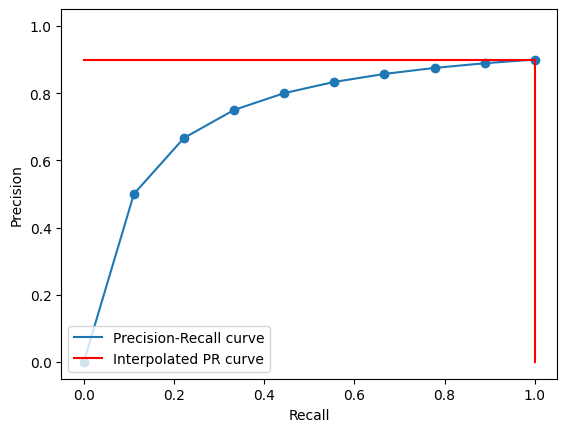

	Query 2


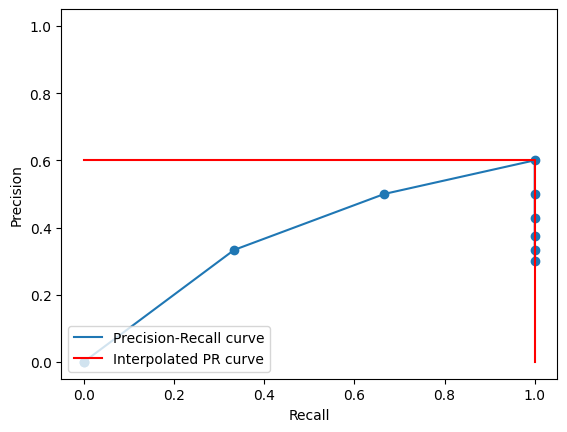

	Query 3


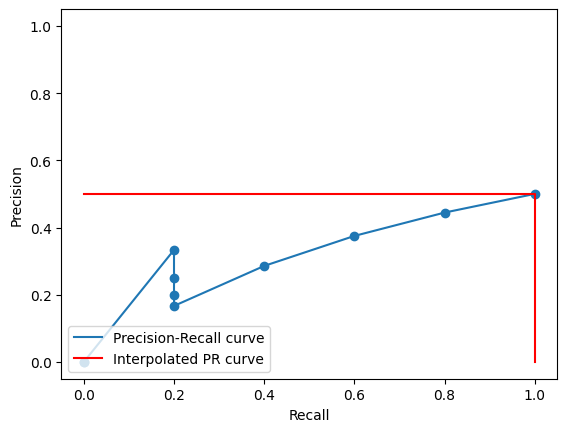

	Query 4


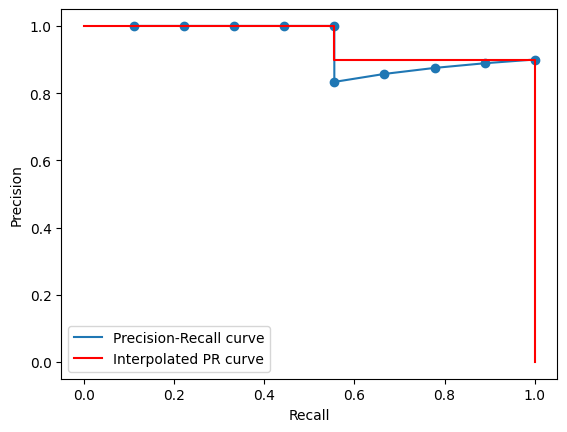

	Query 5


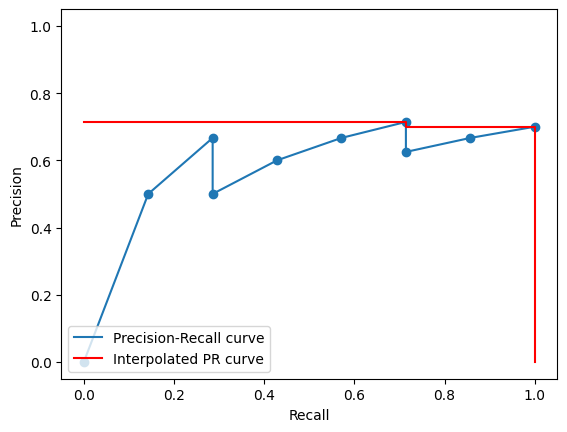

In [23]:
Q = []
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    Q.append(np.array(retrieved_documents.index))
    
R = []
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    R.append(np.array([1 if data.loc[article_id, 'Category'] in user_interests[user_id] else -1 for article_id in retrieved_documents.index])
)
    
evaluate('prec_rec', Q, R)

In [24]:
evaluate('r-prec', Q, R)

Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=0/1=0.00,	R(1)=0/9=0.00
		P(2)=1/2=0.50,	R(2)=1/9=0.11
		P(3)=2/3=0.67,	R(3)=2/9=0.22
		P(4)=3/4=0.75,	R(4)=3/9=0.33
		P(5)=4/5=0.80,	R(5)=4/9=0.44
		P(6)=5/6=0.83,	R(6)=5/9=0.56
		P(7)=6/7=0.86,	R(7)=6/9=0.67
		P(8)=7/8=0.88,	R(8)=7/9=0.78
		P(9)=8/9=0.89,	R(9)=8/9=0.89
		P(10)=9/10=0.90,	R(10)=9/9=1.00
	Query 2
		P(1)=0/1=0.00,	R(1)=0/3=0.00
		P(2)=0/2=0.00,	R(2)=0/3=0.00
		P(3)=1/3=0.33,	R(3)=1/3=0.33
		P(4)=2/4=0.50,	R(4)=2/3=0.67
		P(5)=3/5=0.60,	R(5)=3/3=1.00
		P(6)=3/6=0.50,	R(6)=3/3=1.00
		P(7)=3/7=0.43,	R(7)=3/3=1.00
		P(8)=3/8=0.38,	R(8)=3/3=1.00
		P(9)=3/9=0.33,	R(9)=3/3=1.00
		P(10)=3/10=0.30,	R(10)=3/3=1.00
	Query 3
		P(1)=0/1=0.00,	R(1)=0/5=0.00
		P(2)=0/2=0.00,	R(2)=0/5=0.00
		P(3)=1/3=0.33,	R(3)=1/5=0.20
		P(4)=1/4=0.25,	R(4)=1/5=0.20
		P(5)=1/5=0.20,	R(5)=1/5=0.20
		P(6)=1/6=0.17,	R(6)=1/5=0.20
		P(7)=2/7=0.29,	R(7)=2/5=0.40
		P(8)=3/8=0.38,	R(8)=3/5=0.60
		P(9)=4/9=0.44,	R(9)=4/5=0.80
		P(10)=5/10=0.50,	R(10)=5/

In [25]:
evaluate('map', Q, R)

Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=0/1=0.00,	R(1)=0/9=0.00
		P(2)=1/2=0.50,	R(2)=1/9=0.11
		P(3)=2/3=0.67,	R(3)=2/9=0.22
		P(4)=3/4=0.75,	R(4)=3/9=0.33
		P(5)=4/5=0.80,	R(5)=4/9=0.44
		P(6)=5/6=0.83,	R(6)=5/9=0.56
		P(7)=6/7=0.86,	R(7)=6/9=0.67
		P(8)=7/8=0.88,	R(8)=7/9=0.78
		P(9)=8/9=0.89,	R(9)=8/9=0.89
		P(10)=9/10=0.90,	R(10)=9/9=1.00
	Query 2
		P(1)=0/1=0.00,	R(1)=0/3=0.00
		P(2)=0/2=0.00,	R(2)=0/3=0.00
		P(3)=1/3=0.33,	R(3)=1/3=0.33
		P(4)=2/4=0.50,	R(4)=2/3=0.67
		P(5)=3/5=0.60,	R(5)=3/3=1.00
		P(6)=3/6=0.50,	R(6)=3/3=1.00
		P(7)=3/7=0.43,	R(7)=3/3=1.00
		P(8)=3/8=0.38,	R(8)=3/3=1.00
		P(9)=3/9=0.33,	R(9)=3/3=1.00
		P(10)=3/10=0.30,	R(10)=3/3=1.00
	Query 3
		P(1)=0/1=0.00,	R(1)=0/5=0.00
		P(2)=0/2=0.00,	R(2)=0/5=0.00
		P(3)=1/3=0.33,	R(3)=1/5=0.20
		P(4)=1/4=0.25,	R(4)=1/5=0.20
		P(5)=1/5=0.20,	R(5)=1/5=0.20
		P(6)=1/6=0.17,	R(6)=1/5=0.20
		P(7)=2/7=0.29,	R(7)=2/5=0.40
		P(8)=3/8=0.38,	R(8)=3/5=0.60
		P(9)=4/9=0.44,	R(9)=4/5=0.80
		P(10)=5/10=0.50,	R(10)=5/

# Doc Embeddings

In [26]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Tokenizar los documentos y crear objetos TaggedDocument
tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(data['Text'])]

# Entrenar el modelo Doc2Vec

model = Doc2Vec(window=5, min_count=1, workers=4, epochs=20)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

user_retrieved_documents: Dict[int, pd.DataFrame] = {
    user_id: pd.DataFrame(
        index=data.index,
        columns=['SimilarityScore']
    )
    for user_id, _ in user_interests.items()
}

document_embeddings = [model.dv[str(i)] for i in range(len(data['Text']))]

# Process user queries
for user_id, interests in user_interests.items():
    print(f'User {user_id} have interests: [{", ".join(interests)}]')
    # Aggregate word embeddings for the user's interests to generate the query embedding
    interests_simplified = word_simplifier.simplify(interests)
    top_k_to_print = num_documents_to_retrieve
    query_embedding = model.infer_vector(interests_simplified)
    similarity_scores = cosine_similarity(query_embedding.reshape(1, -1), document_embeddings)[0]
    top_documents_indices = similarity_scores.argsort()[::-1]
    for document_index in top_documents_indices:
        article_id = data.index[document_index]
        user_retrieved_documents[user_id].loc[article_id] = similarity_scores[document_index]
        if top_k_to_print > 0:
                print(f'\tDocument {article_id} with similarity score {similarity_scores[document_index]:.2f}'
                      f' and category {data.loc[article_id, "Category"]} -> {'OK' if data.loc[article_id, "Category"] in interests else 'WRONG'}')
                top_k_to_print -= 1

User 1 have interests: [politics]
	Document 2084 with similarity score 0.75 and category politics -> OK
	Document 1570 with similarity score 0.74 and category politics -> OK
	Document 1258 with similarity score 0.74 and category tech -> WRONG
	Document 828 with similarity score 0.73 and category politics -> OK
	Document 494 with similarity score 0.72 and category politics -> OK
	Document 792 with similarity score 0.72 and category politics -> OK
	Document 882 with similarity score 0.72 and category politics -> OK
	Document 2039 with similarity score 0.72 and category business -> WRONG
	Document 1001 with similarity score 0.72 and category sport -> WRONG
	Document 1260 with similarity score 0.72 and category politics -> OK
User 2 have interests: [entertainment]
	Document 503 with similarity score 0.74 and category sport -> WRONG
	Document 1937 with similarity score 0.70 and category tech -> WRONG
	Document 101 with similarity score 0.70 and category entertainment -> OK
	Document 312 wit

In [27]:
user_retrieved_documents[2].sort_values(by='SimilarityScore', ascending=False).head(num_documents_to_retrieve)

,SimilarityScore
ArticleId,
503,0.742175
1937,0.704226
101,0.697506
312,0.695922
1145,0.691005
636,0.690225
522,0.685296
2221,0.683662
1619,0.682604


Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=1/1=1.00,	R(1)=1/7=0.14
		P(2)=2/2=1.00,	R(2)=2/7=0.29
		P(3)=2/3=0.67,	R(3)=2/7=0.29
		P(4)=3/4=0.75,	R(4)=3/7=0.43
		P(5)=4/5=0.80,	R(5)=4/7=0.57
		P(6)=5/6=0.83,	R(6)=5/7=0.71
		P(7)=6/7=0.86,	R(7)=6/7=0.86
		P(8)=6/8=0.75,	R(8)=6/7=0.86
		P(9)=6/9=0.67,	R(9)=6/7=0.86
		P(10)=7/10=0.70,	R(10)=7/7=1.00
	Query 2
		P(1)=0/1=0.00,	R(1)=0/3=0.00
		P(2)=0/2=0.00,	R(2)=0/3=0.00
		P(3)=1/3=0.33,	R(3)=1/3=0.33
		P(4)=1/4=0.25,	R(4)=1/3=0.33
		P(5)=2/5=0.40,	R(5)=2/3=0.67
		P(6)=2/6=0.33,	R(6)=2/3=0.67
		P(7)=2/7=0.29,	R(7)=2/3=0.67
		P(8)=2/8=0.25,	R(8)=2/3=0.67
		P(9)=2/9=0.22,	R(9)=2/3=0.67
		P(10)=3/10=0.30,	R(10)=3/3=1.00
	Query 3
		P(1)=1/1=1.00,	R(1)=1/8=0.12
		P(2)=2/2=1.00,	R(2)=2/8=0.25
		P(3)=3/3=1.00,	R(3)=3/8=0.38
		P(4)=4/4=1.00,	R(4)=4/8=0.50
		P(5)=5/5=1.00,	R(5)=5/8=0.62
		P(6)=5/6=0.83,	R(6)=5/8=0.62
		P(7)=6/7=0.86,	R(7)=6/8=0.75
		P(8)=7/8=0.88,	R(8)=7/8=0.88
		P(9)=7/9=0.78,	R(9)=7/8=0.88
		P(10)=8/10=0.80,	R(10)=8/

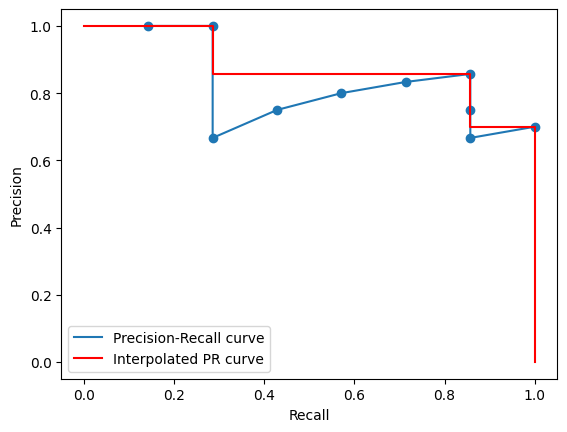

	Query 2


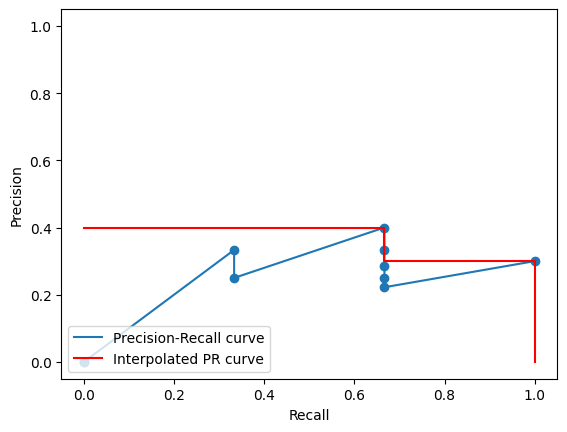

	Query 3


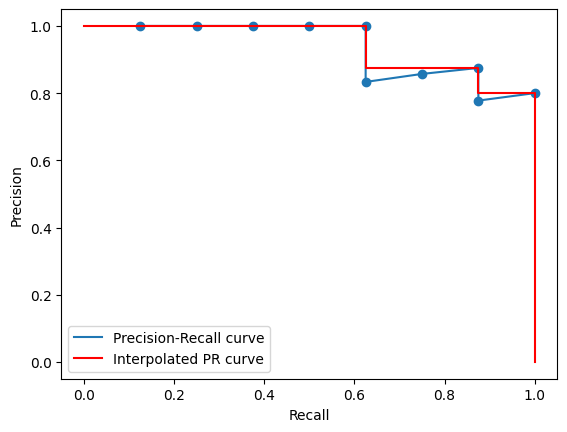

	Query 4


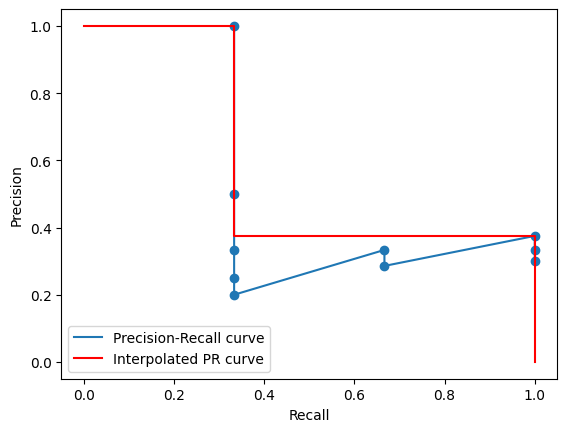

	Query 5


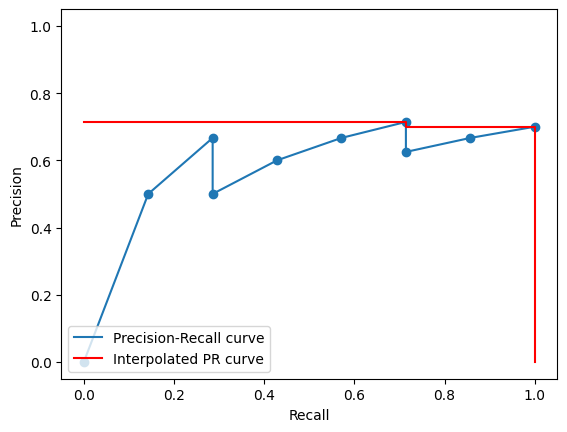

In [28]:
Q = []
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    Q.append(np.array(retrieved_documents.index))
    
R = []
for user_id, retrieved_documents in user_retrieved_documents.items():
    retrieved_documents = retrieved_documents.sort_values(by='SimilarityScore', ascending=False)
    retrieved_documents = retrieved_documents.head(num_documents_to_retrieve)
    R.append(np.array([1 if data.loc[article_id, 'Category'] in user_interests[user_id] else -1 for article_id in retrieved_documents.index])
)

evaluate('prec_rec', Q, R)

In [29]:
evaluate('r-prec', Q, R)

Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=1/1=1.00,	R(1)=1/7=0.14
		P(2)=2/2=1.00,	R(2)=2/7=0.29
		P(3)=2/3=0.67,	R(3)=2/7=0.29
		P(4)=3/4=0.75,	R(4)=3/7=0.43
		P(5)=4/5=0.80,	R(5)=4/7=0.57
		P(6)=5/6=0.83,	R(6)=5/7=0.71
		P(7)=6/7=0.86,	R(7)=6/7=0.86
		P(8)=6/8=0.75,	R(8)=6/7=0.86
		P(9)=6/9=0.67,	R(9)=6/7=0.86
		P(10)=7/10=0.70,	R(10)=7/7=1.00
	Query 2
		P(1)=0/1=0.00,	R(1)=0/3=0.00
		P(2)=0/2=0.00,	R(2)=0/3=0.00
		P(3)=1/3=0.33,	R(3)=1/3=0.33
		P(4)=1/4=0.25,	R(4)=1/3=0.33
		P(5)=2/5=0.40,	R(5)=2/3=0.67
		P(6)=2/6=0.33,	R(6)=2/3=0.67
		P(7)=2/7=0.29,	R(7)=2/3=0.67
		P(8)=2/8=0.25,	R(8)=2/3=0.67
		P(9)=2/9=0.22,	R(9)=2/3=0.67
		P(10)=3/10=0.30,	R(10)=3/3=1.00
	Query 3
		P(1)=1/1=1.00,	R(1)=1/8=0.12
		P(2)=2/2=1.00,	R(2)=2/8=0.25
		P(3)=3/3=1.00,	R(3)=3/8=0.38
		P(4)=4/4=1.00,	R(4)=4/8=0.50
		P(5)=5/5=1.00,	R(5)=5/8=0.62
		P(6)=5/6=0.83,	R(6)=5/8=0.62
		P(7)=6/7=0.86,	R(7)=6/8=0.75
		P(8)=7/8=0.88,	R(8)=7/8=0.88
		P(9)=7/9=0.78,	R(9)=7/8=0.88
		P(10)=8/10=0.80,	R(10)=8/

In [30]:
evaluate('map', Q, R)

Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=1/1=1.00,	R(1)=1/7=0.14
		P(2)=2/2=1.00,	R(2)=2/7=0.29
		P(3)=2/3=0.67,	R(3)=2/7=0.29
		P(4)=3/4=0.75,	R(4)=3/7=0.43
		P(5)=4/5=0.80,	R(5)=4/7=0.57
		P(6)=5/6=0.83,	R(6)=5/7=0.71
		P(7)=6/7=0.86,	R(7)=6/7=0.86
		P(8)=6/8=0.75,	R(8)=6/7=0.86
		P(9)=6/9=0.67,	R(9)=6/7=0.86
		P(10)=7/10=0.70,	R(10)=7/7=1.00
	Query 2
		P(1)=0/1=0.00,	R(1)=0/3=0.00
		P(2)=0/2=0.00,	R(2)=0/3=0.00
		P(3)=1/3=0.33,	R(3)=1/3=0.33
		P(4)=1/4=0.25,	R(4)=1/3=0.33
		P(5)=2/5=0.40,	R(5)=2/3=0.67
		P(6)=2/6=0.33,	R(6)=2/3=0.67
		P(7)=2/7=0.29,	R(7)=2/3=0.67
		P(8)=2/8=0.25,	R(8)=2/3=0.67
		P(9)=2/9=0.22,	R(9)=2/3=0.67
		P(10)=3/10=0.30,	R(10)=3/3=1.00
	Query 3
		P(1)=1/1=1.00,	R(1)=1/8=0.12
		P(2)=2/2=1.00,	R(2)=2/8=0.25
		P(3)=3/3=1.00,	R(3)=3/8=0.38
		P(4)=4/4=1.00,	R(4)=4/8=0.50
		P(5)=5/5=1.00,	R(5)=5/8=0.62
		P(6)=5/6=0.83,	R(6)=5/8=0.62
		P(7)=6/7=0.86,	R(7)=6/8=0.75
		P(8)=7/8=0.88,	R(8)=7/8=0.88
		P(9)=7/9=0.78,	R(9)=7/8=0.88
		P(10)=8/10=0.80,	R(10)=8/